# Import SMK paintings from API
https://www.smk.dk/article/smk-api/

In [1]:
!pip install requests pillow pandas numpy datasets[vision] keras

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for requests from https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl.metadata
  Obtaining dependency information for pillow from https://files.pythonhosted.org/packages/7a/07/e896b096a77375e78e02ce222ae4fd6014928cd76c691d312060a1645dfa/Pillow-10.0.1-cp310-cp310-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/2f/0e/3b74e8f7c908082793adafb02753477f653ccd7e189f3ba070757d2d0e65/pandas-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/9b/5a/f265a1ba3641d16b5480a217a6aed08cceef09cd173b568cd5351053472a/numpy-1.26.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━

In [2]:
import requests
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset

/home/ucloud/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Testing on one URL page

In [3]:
# this page returns the first 30 items when searching for objects that have images, are paintings and can freely be used (public domain)
smk_url = 'https://api.smk.dk/api/v1/art/search/?keys=*&filters=[has_image:true],[object_names:maleri],[public_domain:true]&offset=0&rows=30'
request = requests.get(smk_url)
json = request.json()

The page is now saved as a json file, which consists of lists with dicts with lists and dicts.. 

In [4]:
json

{'offset': 0,
 'rows': 30,
 'found': 4517,
 'items': [{'id': '1170004265_object',
   'created': '2020-03-21T09:13:05Z',
   'modified': '2023-06-15T06:31:51Z',
   'responsible_department': 'Den Kongelige Maleri- og Skulptursamling',
   'acquisition_date': '2019-12-17T00:00:00Z',
   'acquisition_date_precision': '2019-12-17',
   'content_subject': ['Bretagne'],
   'dimensions': [{'part': 'Netto', 'type': 'højde', 'value': '39.5'},
    {'part': 'Netto', 'type': 'bredde', 'unit': 'centimeter', 'value': '34'}],
   'inscriptions': [{'language': 'Engelsk'}],
   'materials': ['Pap'],
   'object_names': [{'name': 'Maleri'}],
   'production': [{'creator': 'Ballin, Mogens',
     'creator_forename': 'Mogens',
     'creator_surname': 'Ballin',
     'creator_date_of_birth': '1871-03-20T00:00:00.000Z',
     'creator_date_of_death': '1914-01-27T00:00:00.000Z',
     'creator_gender': 'MALE',
     'creator_lref': '8445_person'}],
   'production_date': [{'start': '1891-01-01T00:00:00.000Z',
     'end': '

The 'items' list contains information about the 30 SMK objects in this URL. 

A smaller version of the image (the original images (['image_native]) are around 10000x10000 pixels large) is in a url under ['image_thumbnail']. Information about artist, date and title is also extracted in the following code chunk

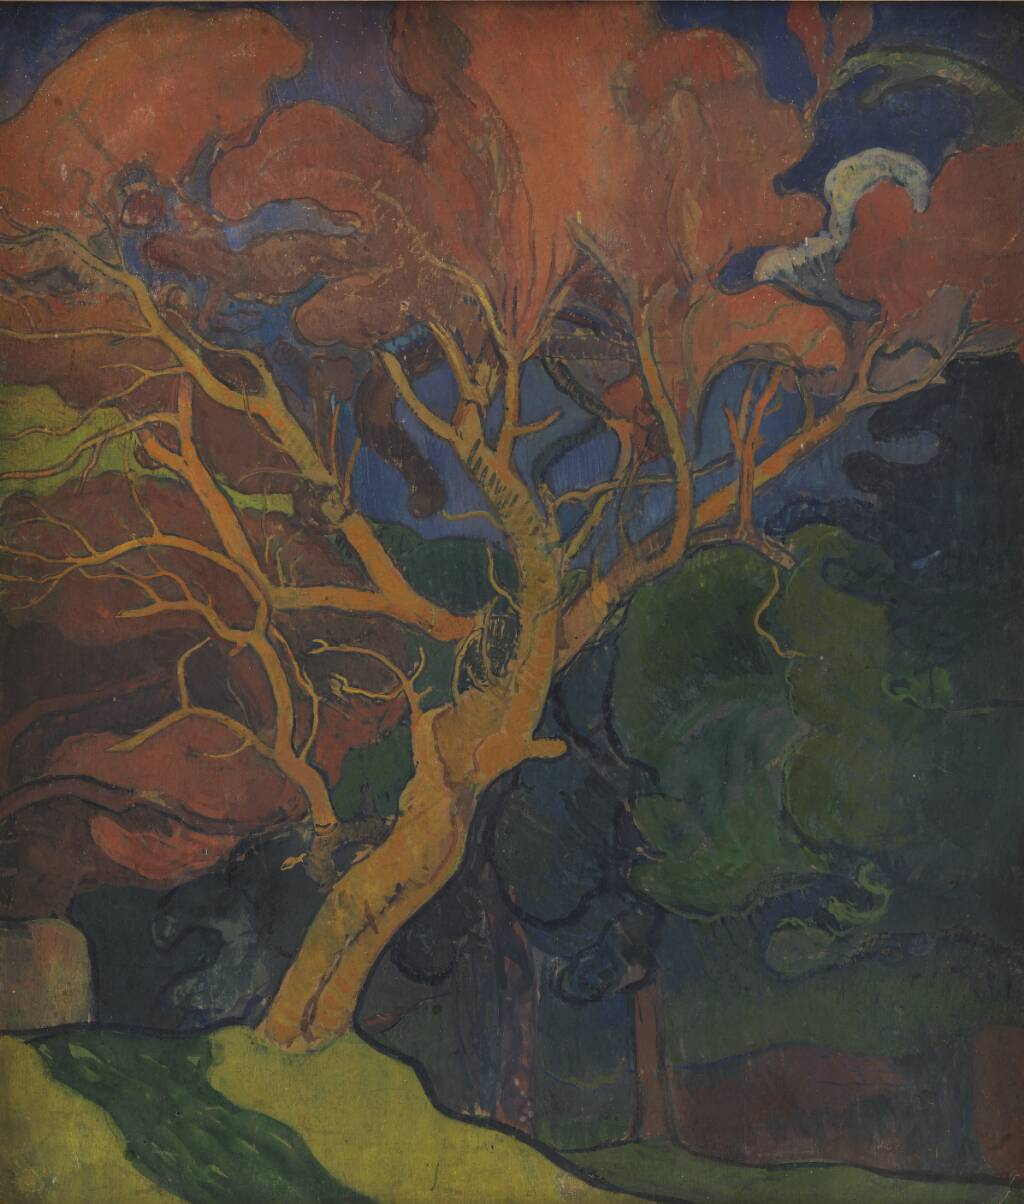

Artist: Mogens Ballin
Date: 1891-1892
Title: Skovinteriør med kroget træ


In [5]:
# find image thumbnail url, information about artist, time period and title from the json file
new_img_url = json['items'][0]['image_thumbnail']
artist = json['items'][0]['artist'][0]
date = json['items'][0]['production_date'][0]['period']
title = json['items'][0]['titles'][0]['title']

# open image in PIL format from the URL
img = Image.open(requests.get(new_img_url, stream = True).raw)

img.show()

print(f"Artist: {artist}")
print(f"Date: {date}")
print(f"Title: {title}")

### All the data

Each url returns a page with 30 SMK objects matching the search keys. To get all the objects, we need to go through all the links possible. This is done by changing the offset parameter and looping over the objects in each new url.

In [14]:
def smk_images():

# initialize empty lists to append data to
    artists = [] # name of the artist
    dates = [] # date of creation
    titles = [] # title of the painting
    object_numbers = [] # SMK object number
    images = [] # PIl image

    # the images needs to be encoded to Image Data (a dict with keys 'path' and 'bytes')
    feature = Image_ds(decode=False)

    # the search returned 4517 objects (paintings)
    for i in range(0, 4517, 30):

        # the api only show 30 returned objects, so we change the 'offset' parameter to get the next 30
        url = 'https://api.smk.dk/api/v1/art/search/?keys=*&filters=[has_image:true],[object_names:maleri],[public_domain:true]&offset=' + str(i) + '&rows=30'
    
        # request url
        req = requests.get(url)

        # save returned json file to a variable
        json = req.json()

        for i in range(len(json['items'])):

            object_no = json['items'][i]['object_number']

            artist = json['items'][i]['artist'][0]
            artists.append(artist)

            date = json['items'][i]['production_date'][0]['period']
            dates.append(date)

            title = json['items'][i]['titles'][0]['title']
            titles.append(title)

            image_thumbnail = json['items'][i]['image_thumbnail']
            img = Image.open(requests.get(image_thumbnail, stream = True).raw)
            
            # encode the PIl images to Data format
            new_image = feature.encode_example(img)
            images.append(new_image)
    
    data = {'title': titles,
        'artist': artists,
        'date': dates,
        'image': images}

    df = pd.DataFrame(data)

    return df

In [8]:
df = smk_images()

In [9]:
from datasets import Dataset

# convert the pandas dataframe to a Huggingface dataset and change the image column back to PIl images
ds = Dataset.from_pandas(df).cast_column('image', Image_ds(decode=True))

In [15]:
testy = smk_images()

KeyboardInterrupt: 

In [23]:
feature = Image_ds(decode=True)
tester = feature.encode_example(img)

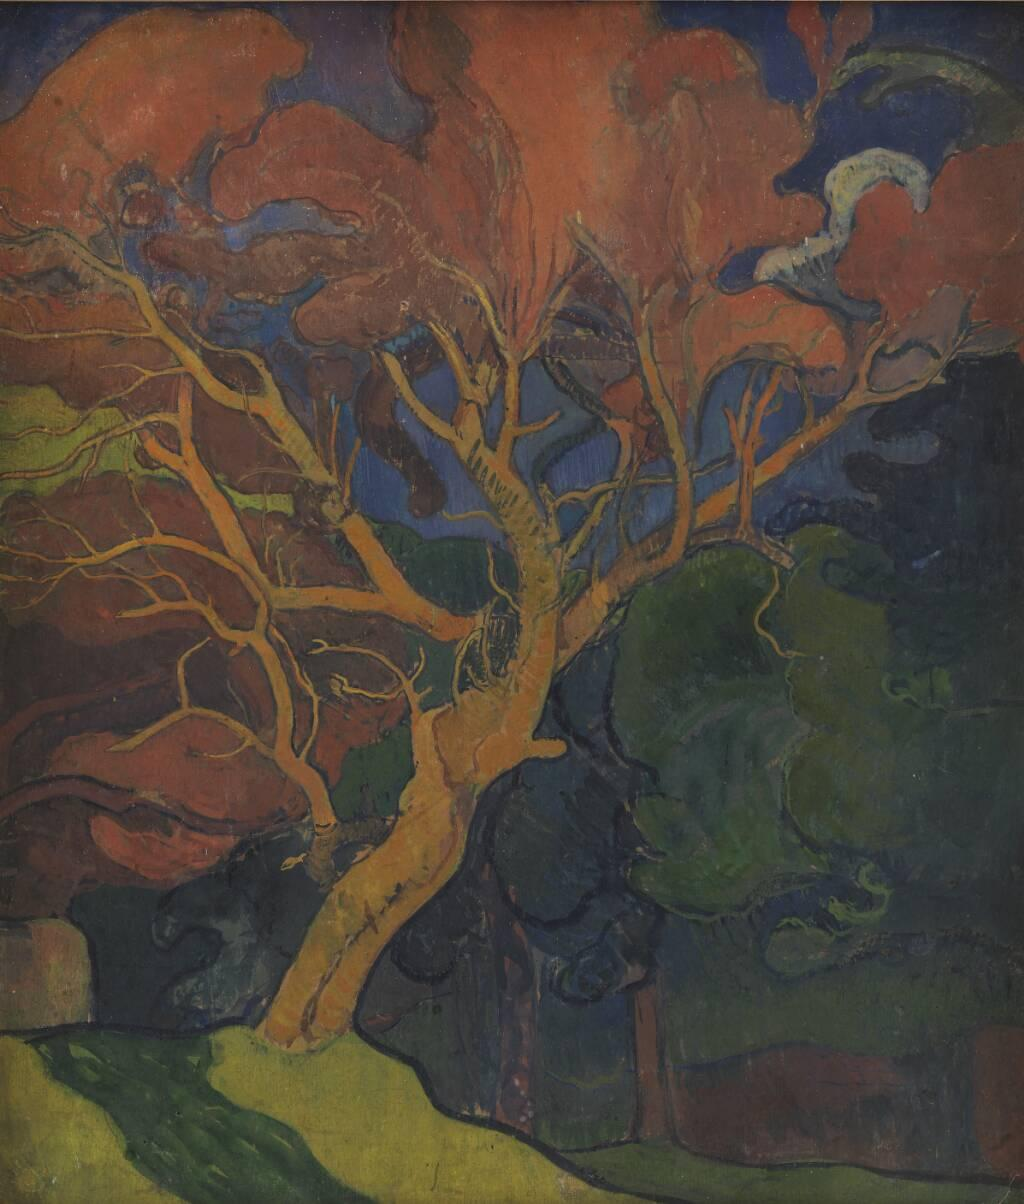

In [24]:
feature.decode_example(tester)

In [13]:
testy[0]['image']

{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xfe\x00\x17Generated by IIPImage\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x04\xb4\x04\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\x

In [10]:
# the dataset can be saved locally
ds.save_to_disk("smk")
#ds_tester = datasets.load_from_disk("smk")

Saving the dataset (2/2 shards): 100%|██████████| 4517/4517 [00:01<00:00, 2812.45 examples/s]
